In [1]:
library(ArchR)
addArchRThreads(threads = 16)
addArchRGenome("hg19")
library(BSgenome.Dmelanogaster.UCSC.dm6)



                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

#### ATAC-SEQ
##### 1. Identifies regions of open chromatin, nucleosome positioning, and transcription factor binding sites across the genome
##### 2. Insights into gene regulatory elements


#### ArchR
##### 1. Fragments: A table or genomic ranges object containing
###### a. Offset-adjusted single-base chromosome start position
###### b. Offset-adjusted single-base chromosome end position
###### c. Unique cellular barcode ID corresponding to each sequenced fragment
##### 2. Insertions: Offset-adjusted single-base position at the very center of an accessible site

In [2]:
if (!requireNamespace("TxDb.Dmelanogaster.UCSC.dm6.ensGene", quietly = TRUE)){
  BiocManager::install("TxDb.Dmelanogaster.UCSC.dm6.ensGene")
}
if (!requireNamespace("org.Dm.eg.db", quietly = TRUE)){
  BiocManager::install("org.Dm.eg.db")
}
library(TxDb.Dmelanogaster.UCSC.dm6.ensGene)
library(org.Dm.eg.db)



Loading required package: GenomicFeatures

Loading required package: AnnotationDbi



In [3]:
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.Dmelanogaster.UCSC.dm6)

Getting genome..

Attempting to infer chromSizes..

Attempting to infer blacklist..

Blacklist not downloaded! Continuing without, be careful for downstream biases..



In [4]:
geneAnnotation <- createGeneAnnotation(TxDb = TxDb.Dmelanogaster.UCSC.dm6.ensGene, OrgDb = org.Dm.eg.db)

Getting Genes..

  1 gene was dropped because it has exons located on both strands of the
  same reference sequence or on more than one reference sequence, so
  cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Determined Annotation Style = ENSEMBL

Getting Exons..

Getting TSS..



In [5]:
geneAnnotation <- createGeneAnnotation(
  TSS = geneAnnotation$TSS, 
  exons = geneAnnotation$exons, 
  genes = geneAnnotation$genes
)

In [8]:
inputFiles <- getTutorialData("Hematopoiesis")
print(inputFiles)

                                      scATAC_BMMC_R1 
     "HemeFragments/scATAC_BMMC_R1.fragments.tsv.gz" 
                                 scATAC_CD34_BMMC_R1 
"HemeFragments/scATAC_CD34_BMMC_R1.fragments.tsv.gz" 
                                      scATAC_PBMC_R1 
     "HemeFragments/scATAC_PBMC_R1.fragments.tsv.gz" 


#### ArrowFile: The base unit of an analytical project in ArchR
##### 1. Each Arrow file stores all of the data associated with an individual sample
###### a. Metadata
###### b. Accessible fragmentsMetadata
###### c. Data matrices
##### 2. ArchR adds info & modifies Arrow file
##### 3. HDF5-format file, R independent


In [9]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  filterTSS = 4, #Dont set this too high because you can always increase later
  filterFrags = 1000,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

filterFrags is no longer a valid input. Please use minFrags! Setting filterFrags value to minFrags!

filterTSS is no longer a valid input. Please use minTSS! Setting filterTSS value to minTSS!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

ArchR logging to : ArchRLogs/ArchR-createArrows-1b044342e4a1-Date-2024-09-04_Time-18-15-43.65618.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2024-09-04 18:15:43.677155 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-1b044342e4a1-Date-2024-09-04_Time-18-15-43.65618.log



####  Doublet
##### 1. Def: A single droplet that received a single barcoded bead and more than one nucleus
##### 2. Causes the reads from more than one cell to appear as a single cell
##### 3. Even at the lower levels of doublets that result from standard kit use, more than 5% of the data may come from doublets
##### 4. They look like a mixture between two cell types and this can be confounded with intermediate cell types or cell states
##### 5. Predict doublets:
###### a. Synthesize in silico doublets from the data by mixing the reads from thousands of combinations of individual cells
###### b. Project these synthetic doublets into the UMAP embedding and identify their nearest neighbor
###### c. Iterating this procedure thousands of times, identify “cells” similar to synthetic doublets signal



In [10]:
doubScores <- addDoubletScores(
    input = ArrowFiles,
    k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
    knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search with doublet projection.
    LSIMethod = 1,
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-1b043b9e846f-Date-2024-09-04_Time-18-15-47.027305.log
If there is an issue, please report to github with logFile!

2024-09-04 18:15:47.047585 : Batch Execution w/ safelapply!, 0 mins elapsed.

2024-09-04 18:15:47.053788 : scATAC_BMMC_R1 (1 of 3) :  Computing Doublet Statistics, 0 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.99066

scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.99066




************************************************************
2024-09-04 18:16:43.690473 : ERROR Found in ggplot for scATAC_BMMC_R1 (1 of 3) :  
LogFile = ArchRLogs/ArchR-addDoubletScores-1b043b9e846f-Date-2024-09-04_Time-18-15-47.027305.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2024-09-04 18:16:43.705708 : scATAC_CD34_BMMC_R1 (2 of 3) :  Computing Doublet Statistics, 0.944 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
scATAC_CD34_BMMC_R1 (2 of 3) : UMAP Projection R^2 = 0.99204

scATAC_CD34_BMMC_R1 (2 of 3) : UMAP Projection R^2 = 0.99204




************************************************************
2024-09-04 18:17:25.156403 : ERROR Found in ggplot for scATAC_CD34_BMMC_R1 (2 of 3) :  
LogFile = ArchRLogs/ArchR-addDoubletScores-1b043b9e846f-Date-2024-09-04_Time-18-15-47.027305.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2024-09-04 18:17:25.169552 : scATAC_PBMC_R1 (3 of 3) :  Computing Doublet Statistics, 1.635 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
scATAC_PBMC_R1 (3 of 3) : UMAP Projection R^2 = 0.99639

scATAC_PBMC_R1 (3 of 3) : UMAP Projection R^2 = 0.99639




************************************************************
2024-09-04 18:18:05.075399 : ERROR Found in ggplot for scATAC_PBMC_R1 (3 of 3) :  
LogFile = ArchRLogs/ArchR-addDoubletScores-1b043b9e846f-Date-2024-09-04_Time-18-15-47.027305.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-1b043b9e846f-Date-2024-09-04_Time-18-15-47.027305.log



#### Create archrproject

In [11]:
projHeme1 <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = "HemeTutorial",
  copyArrows = TRUE, #This is recommened so that if you modify the Arrow files you have an original copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Validating Arrows...

Getting SampleNames...



Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 


Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--'

In [12]:
paste0("Memory Size = ", round(object.size(projHeme1) / 10^6, 3), " MB")

[1] "Memory Size = 37.477 MB"

In [13]:
print(getAvailableMatrices(projHeme1))

[1] "GeneScoreMatrix" "TileMatrix"     


In [14]:
print(head(projHeme1$cellNames))

[1] "scATAC_BMMC_R1#TTATGTCAGTGATTAG-1" "scATAC_BMMC_R1#AAGATAGTCACCGCGA-1"
[3] "scATAC_BMMC_R1#GCATTGAAGATTCCGT-1" "scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1"
[5] "scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1" "scATAC_BMMC_R1#AGTTACGAGAACGTCG-1"


In [15]:
print(head(projHeme1$Sample))

[1] "scATAC_BMMC_R1" "scATAC_BMMC_R1" "scATAC_BMMC_R1" "scATAC_BMMC_R1"
[5] "scATAC_BMMC_R1" "scATAC_BMMC_R1"


In [16]:
print(quantile(projHeme1$TSSEnrichment))

      0%      25%      50%      75%     100% 
 4.10900 13.92550 16.81500 19.93025 41.98000 


In [17]:
projHeme1[projHeme1$cellNames[1:100], ]


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/qp2134/decipher/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 100
medianTSS(1): 10.794
medianFrags(1): 10200.5

#### ArchR Data Manipulation

In [18]:
idxSample <- BiocGenerics::which(projHeme1$Sample %in% "scATAC_BMMC_R1")
cellsSample <- projHeme1$cellNames[idxSample]
projHeme1[cellsSample, ]


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/qp2134/decipher/HemeTutorial 
samples(3): scATAC_BMMC_R1 scATAC_CD34_BMMC_R1 scATAC_PBMC_R1
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... DoubletEnrichment
  BlacklistRatio
numberOfCells(1): 4932
medianTSS(1): 15.2575
medianFrags(1): 2771

In [19]:
getCellColData(projHeme1, select = c("bioNames"))

ERROR: Error in value[[3L]](cond): select Not Found in Colnames of cellColData:
[1m[33mError[39m in `dplyr::mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `tmpNewCol123 = eval(parse(text = select[x]))`.
[1mCaused by error:[22m
[33m![39m object 'bioNames' not found



In [ ]:
df <- getCellColData(projHeme1, select = "nFrags")
df

DataFrame with 10660 rows and 1 column
                                     nFrags
                                  <numeric>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1     26189
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1     20648
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1     18990
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1     18296
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1     17458
...                                     ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1      1038
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1      1037
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1      1033
scATAC_PBMC_R1#TTCGTTACATTGAACC-1      1033
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1      1002

In [ ]:
df <- getCellColData(projHeme1, select = c("log10(nFrags)", "nFrags - 1"))
df

DataFrame with 10660 rows and 2 columns
                                  log10(nFrags) nFrags - 1
                                      <numeric>  <numeric>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1       4.41812      26188
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1       4.31488      20647
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1       4.27852      18989
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1       4.26236      18295
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1       4.24199      17457
...                                         ...        ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1       3.01620       1037
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1       3.01578       1036
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1       3.01410       1032
scATAC_PBMC_R1#TTCGTTACATTGAACC-1       3.01410       1032
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1       3.00087       1001

In [ ]:
df <- getCellColData(projHeme1, select = c("log10(nFrags)", "TSSEnrichment"))
df

DataFrame with 10660 rows and 2 columns
                                  log10(nFrags) TSSEnrichment
                                      <numeric>     <numeric>
scATAC_BMMC_R1#TTATGTCAGTGATTAG-1       4.41812         7.204
scATAC_BMMC_R1#AAGATAGTCACCGCGA-1       4.31488         7.949
scATAC_BMMC_R1#GCATTGAAGATTCCGT-1       4.27852         4.447
scATAC_BMMC_R1#TATGTTCAGGGTTCCC-1       4.26236         6.941
scATAC_BMMC_R1#TCCATCGGTCCCGTGA-1       4.24199         4.771
...                                         ...           ...
scATAC_PBMC_R1#GCTGCGAAGATCCGAG-1       3.01620        24.257
scATAC_PBMC_R1#GCAGCTGGTGGCCTTG-1       3.01578        22.537
scATAC_PBMC_R1#GCAGATTGTACGCAAG-1       3.01410        19.888
scATAC_PBMC_R1#TTCGTTACATTGAACC-1       3.01410        30.000
scATAC_PBMC_R1#CGCTATCGTGAGGTCA-1       3.00087        21.287

#### Plotting

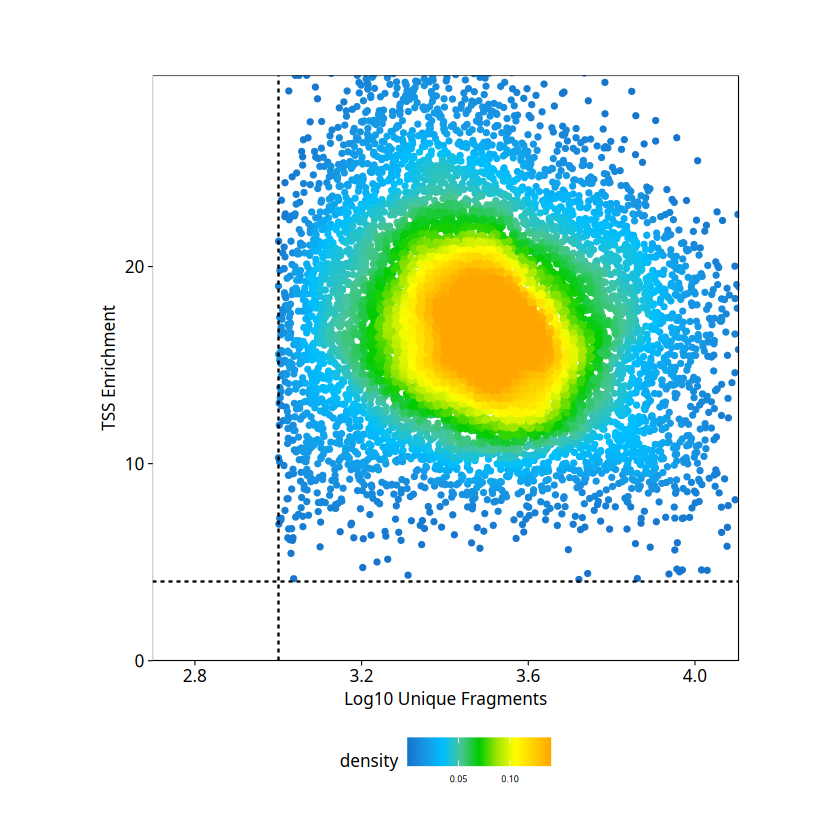

In [ ]:
p <- ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(log10(500), quantile(df[,1], probs = 0.99)),
    ylim = c(0, quantile(df[,2], probs = 0.99))
) + geom_hline(yintercept = 4, lty = "dashed") + geom_vline(xintercept = 3, lty = "dashed")
p

1 


Picking joint bandwidth of 0.89



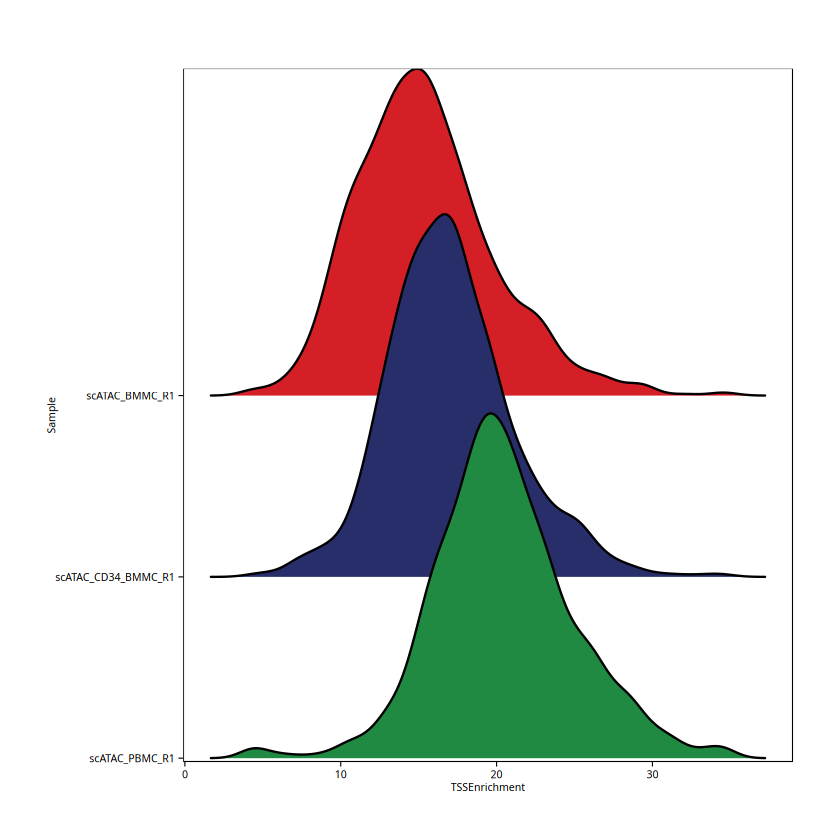

In [ ]:
p1 <- plotGroups(
    ArchRProj = projHeme1,
    groupBy = "Sample",
    colorBy = "cellColData",
    name = "TSSEnrichment",
    plotAs = "ridges"
)
p1

1 




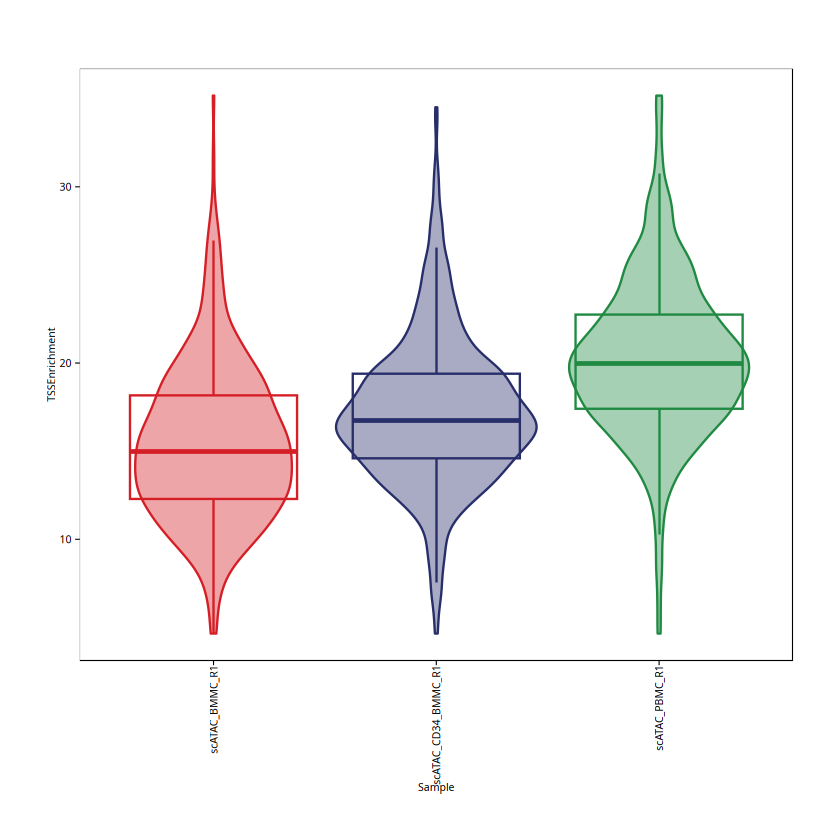

In [ ]:
p2 <- plotGroups(
    ArchRProj = projHeme1,
    groupBy = "Sample",
    colorBy = "cellColData",
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
)
p2

1 


Picking joint bandwidth of 0.0508



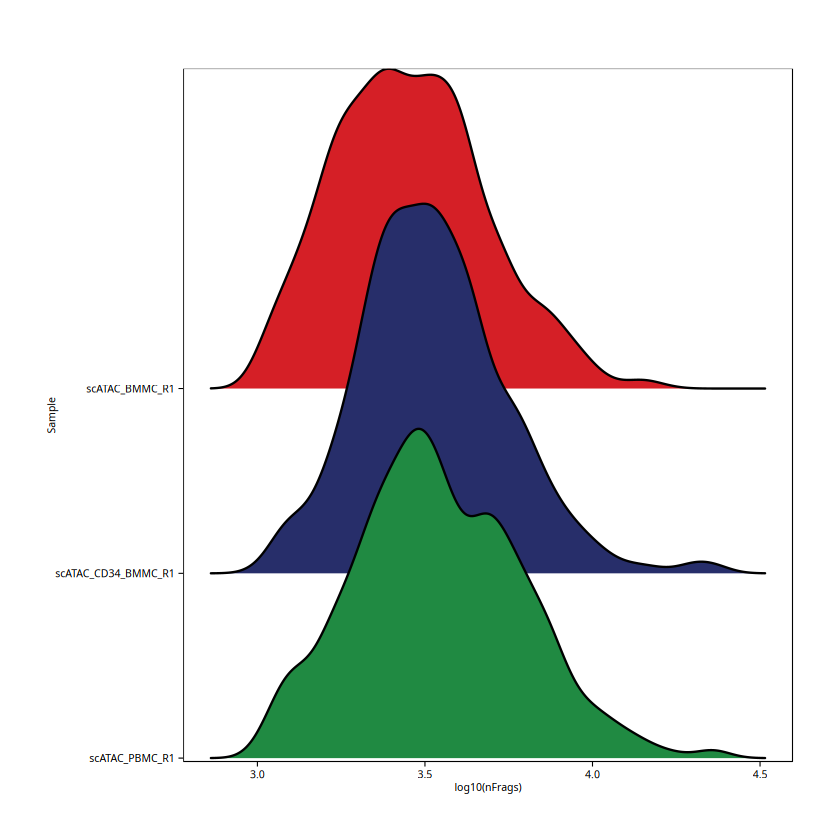

In [ ]:
p3 <- plotGroups(
    ArchRProj = projHeme1, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "ridges"
)
p3

1 




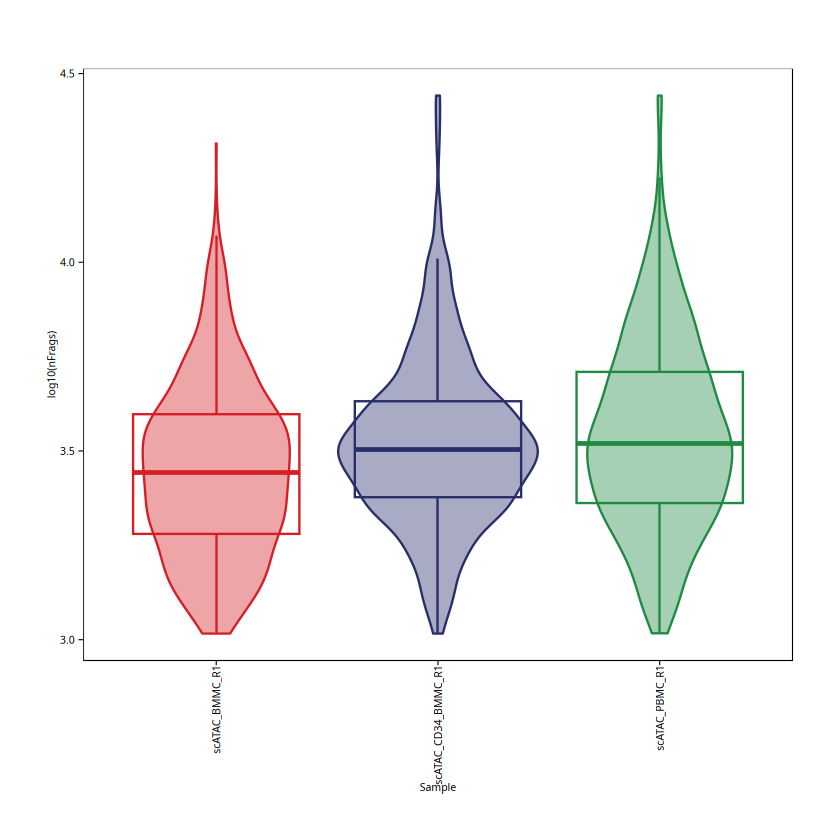

In [ ]:
p4 <- plotGroups(
    ArchRProj = projHeme1, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
)
p4

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-117818ed8c5c-Date-2024-09-03_Time-20-32-11.95896.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-117818ed8c5c-Date-2024-09-03_Time-20-32-11.95896.log



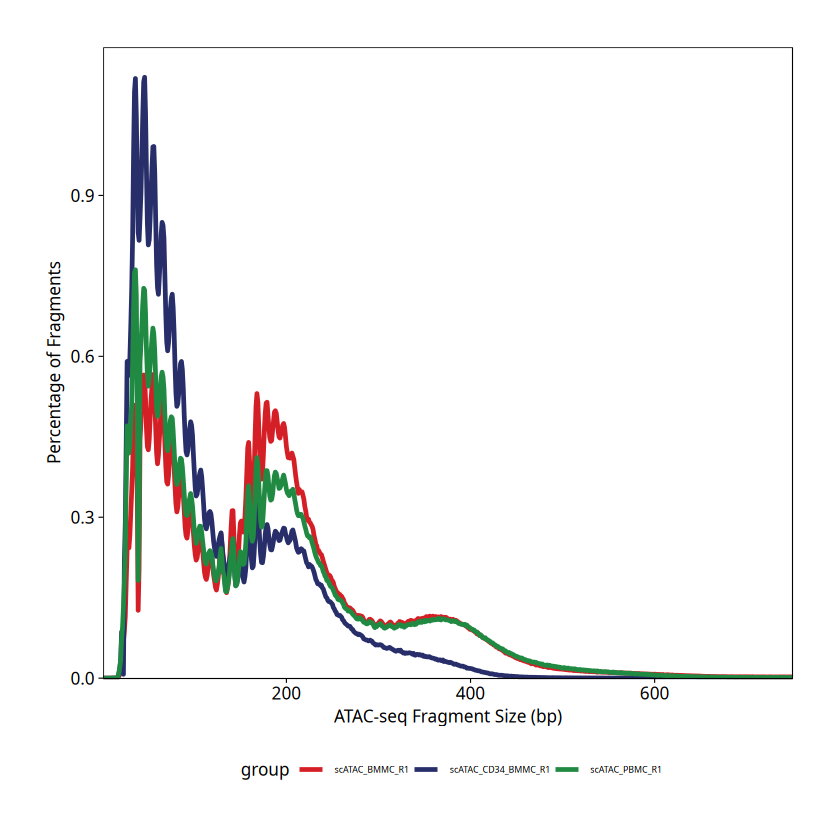

In [ ]:
p1 <- plotFragmentSizes(ArchRProj = projHeme1)
p1

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-1178257e837c-Date-2024-09-03_Time-20-04-53.431839.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-1178257e837c-Date-2024-09-03_Time-20-04-53.431839.log



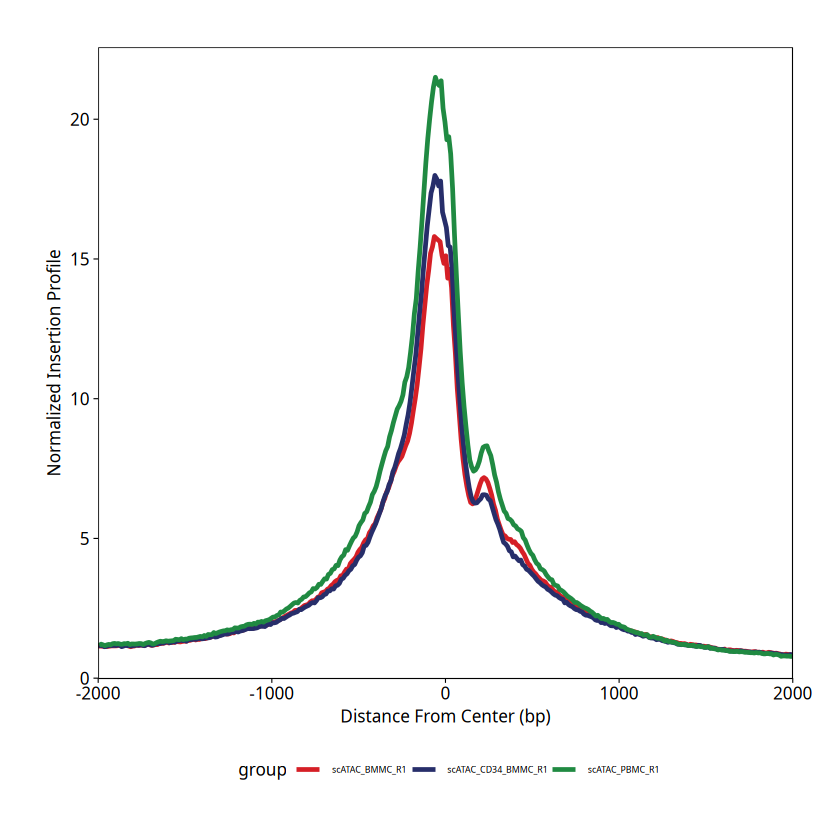

In [ ]:
plotTSSEnrichment(ArchRProj = projHeme1)

#### Save project

In [ ]:
saveArchRProject(ArchRProj = projHeme1, outputDirectory = "Save-ProjHeme1", load = FALSE)

Copying ArchRProject to new outputDirectory : /home/qp2134/decipher/Save-ProjHeme1

Copying Arrow Files...

Copying Arrow Files (1 of 3)

Copying Arrow Files (2 of 3)

Copying Arrow Files (3 of 3)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 1): Plots

Saving ArchRProject...



In [ ]:
projHeme2 <- filterDoublets(projHeme1)

Filtering 410 cells from ArchRProject!

	scATAC_BMMC_R1 : 243 of 4932 (4.9%)

	scATAC_CD34_BMMC_R1 : 107 of 3275 (3.3%)

	scATAC_PBMC_R1 : 60 of 2453 (2.4%)



In [ ]:
projHeme2 <- addIterativeLSI(
    ArchRProj = projHeme2,
    useMatrix = "TileMatrix",
    name = "IterativeLSI",
    iterations = 2,
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2),
        sampleCells = 10000,
        n.start = 10
    ),
    varFeatures = 25000,
    dimsToUse = 1:30
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-117840871cbb-Date-2024-09-03_Time-20-37-44.629871.log
If there is an issue, please report to github with logFile!

2024-09-03 20:37:44.800864 : Computing Total Across All Features, 0.002 mins elapsed.

2024-09-03 20:37:45.785348 : Computing Top Features, 0.018 mins elapsed.

###########
2024-09-03 20:37:47.210959 : Running LSI (1 of 2) on Top Features, 0.042 mins elapsed.
###########

2024-09-03 20:37:47.246994 : Sampling Cells (N = 10001) for Estimated LSI, 0.043 mins elapsed.

2024-09-03 20:37:47.24872 : Creating Sampled Partial Matrix, 0.043 mins elapsed.

2024-09-03 20:37:53.022926 : Computing Estimated LSI (projectAll = FALSE), 0.139 mins elapsed.

2024-09-03 20:38:21.31017 : Identifying Clusters, 0.61 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2024-09-03 20:38:28.918465 : Identified 6 Clusters, 0.737 mins elapsed.

2024-09-03 20:38:28.923468 : Saving LSI Iteration, 0.737 


************************************************************
2024-09-03 20:38:36.196307 : ERROR Found in .saveIteration for  
LogFile = ArchRLogs/ArchR-addIterativeLSI-117840871cbb-Date-2024-09-03_Time-20-37-44.629871.log

<simpleError in g$grobs[[legend]]: no such index at level 2
>

************************************************************



2024-09-03 20:38:36.198278 : Creating Cluster Matrix on the total Group Features, 0.858 mins elapsed.

2024-09-03 20:38:42.734182 : Computing Variable Features, 0.967 mins elapsed.

###########
2024-09-03 20:38:42.844585 : Running LSI (2 of 2) on Variable Features, 0.969 mins elapsed.
###########

2024-09-03 20:38:42.85708 : Creating Partial Matrix, 0.969 mins elapsed.

2024-09-03 20:38:47.735134 : Computing LSI, 1.051 mins elapsed.

2024-09-03 20:39:13.521861 : Finished Running IterativeLSI, 1.48 mins elapsed.



In [ ]:
projHeme2 <- addIterativeLSI(
    ArchRProj = projHeme2,
    useMatrix = "TileMatrix", 
    name = "IterativeLSI2", 
    iterations = 4, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.1, 0.2, 0.4), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 15000, 
    dimsToUse = 1:30
)

In [ ]:
projHeme2 <- addHarmony(
    ArchRProj = projHeme2,
    reducedDims = "IterativeLSI",
    name = "Harmony",
    groupBy = "Sample"
)

Warning message in (function (...) :
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



In [ ]:
projHeme2 <- addClusters(
    input = projHeme2,
    reducedDims = "IterativeLSI",
    method = "Seurat",
    name = "Clusters",
    resolution = 0.8
)

In [ ]:
markersGS <- getMarkerFeatures(
    ArchRProj = projHeme2, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ERROR: Error in eval(expr, envir, enclos): object 'projHeme2' not found
